In [1]:
using Plots
using FFTW
using NumericalIntegration

In [45]:

# ╔═╡ 31eac102-5cb0-11eb-29f1-2b5dbde52ad7
function arr_mult(arr1, arr2)
    
    result = nothing
    if(eltype(arr1) <: Complex || eltype(arr2) <: Complex)
        result =  zeros(size(arr1)) * 1im
    else
        result = zeros(size(arr1))	
    end
    
    for en in enumerate(arr1)
        
        result[en[1]] = en[2] * arr2[en[1]]
    
    end
    return result
end




# ╔═╡ 824c3340-5cb5-11eb-2065-0f921693205d
function arange_n(N)
        return Array(0:N-1)
end

function make_psi_x(psi_x, k, x, dx)
    return (psi_x .* exp.(-1im * k[1] .*x) * sqrt(2 * pi) / dx)
    end


function get_psi_x(psi_mod_x, k, x, dx)
        return psi_mod_x .*exp.(1im * k[1] .*x)* sqrt(2 * pi) / dx
    end


function make_psi_k(psi_k, x, dk, N)
        return psi_k .* exp.(1im * x[1] .*dk .* arange_n(N) )
        
    end

# ╔═╡ 196807e2-5cbb-11eb-389b-5becb60e5b3f
function get_psi_k(psi_mod_k, x, dk, N)
        return psi_mod_k .* exp.(-1im * x[1] .* dk * arange_n(N))
        
    end

# ╔═╡ 80f9b3e2-5cbb-11eb-025b-6dc128074fb8
begin
# 	function compute_k_from_x(sim::Simulation)
# 		sim.psi_mod_k = fft(sim.psi_mod_x)
# 		return
# 	end
    
# 	function compute_x_from_k(sim::Simulation)
# 		sim.psi_mod_x = ifft(sim.psi_mod_k)
# 	end
    function compute_k_from_x(psi_mod_x)
        return fft(psi_mod_x)
        
    end
    
    function compute_x_from_k(psi_mod_k)
        return ifft(psi_mod_k)
    end
end

# ╔═╡ a49b2bf0-5cb9-11eb-130c-e163102987dc
mutable struct Simulation
    x # Float array
    v_x #Float array
    psi_x #Complex array

    hbar #Float
    m #Float
    t0 #Float
    k #Float array

    dx
    dk

    dt

    x_evolve_half
    x_evolve
    k_evolve

    psi_k 
    psi_mod_x
    psi_mod_k

    function Simulation(x, psi_x0, V_x, k0 = -28, hbar = 1., m = 1., t0 = 0., dt=0.01)

        N = size(x)[1]

        dx = x[2] - x[1];
        dk = 2 * pi / (N * dx);

        if(k0 == nothing)
            k0 = - 0.5 * N * dk
        end

        k =range(1, N, length=N).*dk .+ k0
        x_evolve_half = exp.(-0.5im .* V_x ./ hbar .* dt)
        x_evolve = x_evolve_half .* x_evolve_half
        k_evolve = exp.(-0.5im .* hbar ./ m .* (k.*k) .* dt)

        psi_mod_x = make_psi_x(psi_x0, k, x,dx)

        psi_k = compute_k_from_x(psi_mod_x)

        psi_mod_k = make_psi_k(psi_k, x, dk,N)

        new(x,V_x, psi_x0, hbar, m,t0, k, dx, dk, dt, x_evolve_half, x_evolve, k_evolve, psi_k, psi_mod_x, psi_mod_k)

    #return sim
end

end

# ╔═╡ 7473bfa0-5cb9-11eb-3814-8762c9ee9bf8
function sim_iteration(sim::Simulation)
    
    N = size(sim.psi_mod_x)[1]
    sim.psi_mod_x[1] = 0
    sim.psi_mod_x[N] = 0
    sim.psi_mod_x .*= sim.x_evolve_half
    sim.psi_mod_x[1] = 0
    sim.psi_mod_x[N] = 0
    sim.psi_mod_k = compute_k_from_x(sim.psi_mod_x)
    sim.psi_mod_k .*= sim.k_evolve;
    
    sim.psi_mod_k[1] = 0
    sim.psi_mod_k[N] = 0
    
    sim.psi_mod_x = compute_x_from_k(sim.psi_mod_k)
    sim.psi_mod_x[1] = 0
    sim.psi_mod_x[N] = 0
    sim.psi_mod_x .*= sim.x_evolve

    sim.psi_mod_x .*= sim.x_evolve_half
    
    sim.psi_mod_x[1] = -sim.psi_mod_x[2]
    sim.psi_mod_x[N] = -sim.psi_mod_x[N-1]

    #return get_psi_x(sim.psi_mod_x, sim.k, sim.x, sim.dx)
    return sim.psi_mod_x
end

# ╔═╡ 38ff7850-5cd8-11eb-305b-45fafce7dad0
    

    

# ╔═╡ 2aa0f9e0-5cde-11eb-1d73-e33f91f5193d
function getMomentum(psi_x, x, a)
    const_part = (a * sqrt(pi)) ^ (-0.5)

    exp_part = psi_x ./ const_part
    
    image_part = convert(Array{Float64}, imag.(psi_x))
    
    sqrt_mod = sqrt.(image_part.^2) 
    
    k0_arr = log.(sqrt_mod)
    
    
    return k0_arr
end
    
    
    

# ╔═╡ ee256ca0-5cb8-11eb-3625-575f35c0b028
function integrate_till_p(x, fx, p)
    #println("start")
    dx = x[2]-x[1]
    sum = 0
    for i in 1:size(fx)[1]
        #println("$p, $sum")
        sum += fx[i]*dx
        if(sum >= p)
            x_val = x[i]
            #println("Random p was: $p, found at i=$i, with x=$x_val")
            return x[i]
        end
    end
    return Inf
end

function gauss_x(x, w, x0, k0)
    
    exp_part = (-0.5 * (((x .- x0) /w) .* ((x .- x0) /w)) + 1im .*x .*k0)
    const_part = (w * sqrt(pi)) ^ (-0.5)
    
    return const_part * exp.(exp_part)
    #return ((a * sqrt(pi)) ^ (-0.5) * arr_exp(-0.5 * ((x .- x0) /a) ^ 2 + 1im .*x .*k0))
end
function to_real_normal(x, psi)
        real = abs.(psi .* conj(psi))
        normal = integrate(x, real)
        return real ./normal
end
"""
Contains global characteristics that will be shared by all experiments 
"""
mutable struct GlobalArgs
    N
    dx
    dt
    
    hbar
    mass
    
    vel_0

    t_steps
    
end

# ╔═╡ 389f9d40-5d55-11eb-1c9d-01537d1548c0
struct AnimatableResult
    x
    N
    t_steps
    psi_x_res
end


# ╔═╡ 8bffe9e0-5d55-11eb-2865-77e638194262
function plotAnimationResult(anim::AnimatableResult, file)
    
    
    psi_max = max(anim.psi_x_res ...)
    

    anim_ = Animation()
    #p = plot(x, v_x, size=(600,300))
    #plot!([0], [results[1:N])
    for t in 0:10:anim.t_steps-1

        plot([anim.x], [anim.psi_x_res[(t*anim.N +1):(t+1)*anim.N]], size=(600,300))
        plot!(ylim=(0,psi_max))
        frame(anim_)
        
    end
    gif(anim_, file, fps=200)
end

function plotAnimationResult2(anim::AnimatableResult, file)
    
    
    psi_max = max(anim.psi_x_res ...)
    

    anim_ = Animation()
    #p = plot(x, v_x, size=(600,300))
    #plot!([0], [results[1:N])
    for t in 1:100:anim.t_steps

        plot([anim.x], [anim.psi_x_res[t,:]], size=(600,300))
        plot!(ylim=(0,psi_max))
        frame(anim_)
        
    end
    gif(anim_, file, fps=200)
end


# ╔═╡ 600a20b0-5d52-11eb-1b39-ad226a76aea4
function RunSimulation(gArgs::GlobalArgs, measure_every, iterations, return_result=false, debug=false)
    N = gArgs.N
    
    x = (Array(1:gArgs.N) .- 0.5 * gArgs.N) .* gArgs.dx
    
    p0= sqrt(2 * gArgs.mass * 0.2 * gArgs.vel_0)
    dp2 = p0 * p0 /80.0
    d = gArgs.hbar /sqrt(2*dp2)
    k0 = p0/gArgs.hbar
    v0 = p0/gArgs.mass
    
    x0 = x[1] + 3*d
    
    v_x = zeros(gArgs.N)


    psi_x_results = []
    average_prob = 0
    iteration_10_perc = ceil(iterations * 0.1)
    N_half = Int64(N/2)
    it = 1
    
    while(it <= iterations)
        if(it % iteration_10_perc == 0)
            perc = round(it/iterations * 100, digits=2)
            println("$perc% complete")
        end
        measure_num  = 0
        psi_x0 = gauss_x(x,d, x0, k0)
        #TODO - allow for variable dt
        sim = Simulation(x, psi_x0, v_x)
        psi_sqr_x = []
        for t in 1:gArgs.t_steps
            #run a single iteration
            res = sim_iteration(sim)
            psi_sqr_x = to_real_normal(x, res)
            #If we wish to return a result, we only do so for our first experiment
            if(return_result && it==1)
                append!(psi_x_results, psi_sqr_x)
            end
            
            #If we wish to make a measurement this iteration
            if(t % measure_every == 0)
                measure_num += 1
                #Measure our quantum system
                measure(sim, d)

            end
            
        end
        
        prob = integrate(x[N_half:N],psi_sqr_x[N_half:N])
        average_prob += prob
        #Perform a final measurement
        wave_pos = measure(sim, d)
        it+=1


    end
    
    animResult = AnimatableResult(x,gArgs.N, gArgs.t_steps, psi_x_results)
    
    return animResult,average_prob/iterations
end

mutable struct SystemArgs
    half_width
    dx
    dt
    k0
    t_steps
end

In [46]:
function measure(sim::Simulation, d, allowed)
    #Find probability distribution of current wave
    prob_x = to_real_normal(sim.x, sim.psi_mod_x)

    #up until point x0 such that integrand = p
    p = rand()
    #We find the position of the wave after measurement
    x0 = integrate_till_p(sim.x, prob_x, p)
    
    #If our collapsed wave position is outside of the allowed region, 
    #then our simulation is complete as we have succesfully moved to the new region
    if(x0 <= sim.x[allowed[1]] || x0 >= sim.x[allowed[2]])
        return true
    end
    
    #If we have not gone into the new region, we are still in the old region
    #we collpase the wave function appropriately.
    
    #Find the probability of being in the original region
    P_N = integrate(sim.x[allowed[1]:allowed[2]], prob_x[allowed[1]:allowed[2]])

    sim.psi_mod_x[1:allowed[1]] .= 0
    sim.psi_mod_x[allowed[2]:size(sim.psi_mod_x)[1]] .= 0
    sim.psi_mod_x ./=P_N
    return false
#         #Convert our wave function to a probability dsitribution
#         #do same for k-space
#         psi_k = get_psi_k(sim.psi_mod_k, sim.x, sim.dk, size(sim.x)[1])
#         prob_k = to_real_normal(sim.k, psi_k)

#         #generate a random value ∈ [0,1] , integrate wave function


#         #println(k0)
#         #Find the index of this x coordinate


#         psi_x0 = gauss_x(sim.x, d, x0, k0)

#         sim.psi_mod_x = make_psi_x(psi_x0, sim.k, sim.x,sim.dx)
#         sim.psi_k = compute_k_from_x(sim.psi_mod_x)

# #         println(size(sim.psi_k))
# #         println(size(sim.psi_k))

#         sim.psi_mod_k = make_psi_k(sim.psi_k, sim.x, sim.dk,size(sim.x)[1])

    #return x0

end


measure (generic function with 1 method)

In [51]:
# ╔═╡ 600a20b0-5d52-11eb-1b39-ad226a76aea4
function RunSimulation2(sArgs::SystemArgs, measure_every, iterations, return_result=false, debug=false)
    
    if(measure_every < 0)
        measure_every = sArgs.t_steps + 1
    end
    
    N = Int(10 * sArgs.half_width / sArgs.dx)
        
    x = (Array(1:N) .- 0.5 * N) .* sArgs.dx
    
    x0 = -sArgs.half_width
        
    v_x = zeros(N)
    
    psi_x_results = zeros(sArgs.t_steps, N)
    average_prob = 0
    iteration_10_perc = ceil(iterations * 0.1)
    N_half = Int64(N/2)
    it = 1
    allowed = (1 ,Int(N/2)-100)
    
    
    movement_complete = 0
    
    while(it <= iterations)
        if(it % iteration_10_perc == 0)
            perc = round(it/iterations * 100, digits=2)
            println("$perc% complete")
        end
        measure_num  = 0
        psi_x0 = gauss_x(x,0.5 * sArgs.half_width, x0, sArgs.k0)
        #TODO - allow for variable dt
        sim = Simulation(x, psi_x0, v_x)
        psi_sqr_x = []
        
        has_complete = false
        
        for t in 1:sArgs.t_steps
            #run a single iteration
            res = sim_iteration(sim)
            psi_sqr_x = to_real_normal(x, res)
            #If we wish to return a result, we only do so for our first experiment
            if(return_result && it==1)
                #append!(psi_x_results, psi_sqr_x)
                psi_x_results[t,:] = psi_sqr_x
            end
            
            #If we wish to make a measurement this iteration
            if(t % measure_every == 0)
                measure_num += 1
                
                #Measure our quantum system
                if(measure(sim, sArgs.half_width * 0.5, allowed))
                    movement_complete+=1
                   #println("break: $it , $t")
                    has_complete = true
                    break
                end

            end
            
        end
        
        #Measure our quantum system
        if(!has_complete && measure(sim, sArgs.half_width * 0.5, allowed))
            movement_complete+=1
        end
        
        #prob = integrate(x[1:N_half],psi_sqr_x[1:N_half])
        #average_prob += prob
        #Perform a final measurement
        #wave_pos = measure(sim, sArgs.half_width * 0.5,allowed)
        
        it+=1


    end
    
    animResult = AnimatableResult(x,N, sArgs.t_steps, psi_x_results)
    
    return animResult,movement_complete/iterations
end

RunSimulation2 (generic function with 3 methods)

10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
v =0.5, no measurement, travel prob is 1.0


┌ Info: Saved animation to 
│   fn = /home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_none.gif
└ @ Plots /home/nikita/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_none.gif")
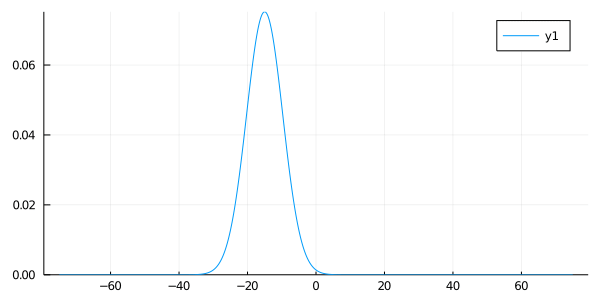

In [52]:
sArgs = SystemArgs(15, 0.01, 0.0001, .5, 8192)

anim, prob   = RunSimulation2(sArgs, -1, 100, true)
println("v =0.5, no measurement, travel prob is $prob")
plotAnimationResult2(anim, "v_05_m_none.gif")

#print(size(x))

#anim.psi_x_res
#plotAnimationResult(anim, "test.gif")

10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
v =0.5, mf=4096, travel prob is 0.99


┌ Info: Saved animation to 
│   fn = /home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_4096.gif
└ @ Plots /home/nikita/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_4096.gif")
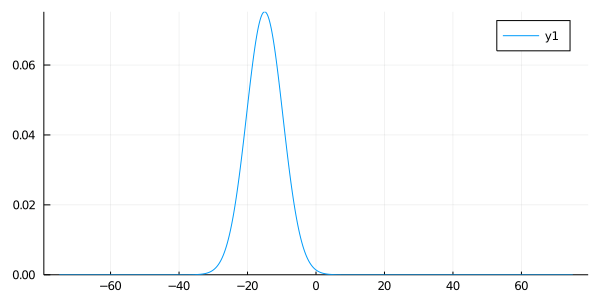

In [53]:
sArgs = SystemArgs(15, 0.01, 0.0001, .5, 8192)

anim, prob   = RunSimulation2(sArgs, 4096, 100, true)
println("v =0.5, mf=4096, travel prob is $prob")
plotAnimationResult2(anim, "v_05_m_4096.gif")

10.0% complete
20.0% complete
30.0% complete
40.0% complete
50.0% complete
60.0% complete
70.0% complete
80.0% complete
90.0% complete
100.0% complete
v =0.5, mf=4096, travel prob is 0.93


┌ Info: Saved animation to 
│   fn = /home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_4096.gif
└ @ Plots /home/nikita/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/home/nikita/Zeno_QM/Quantum/FreeWave/v_05_m_4096.gif")
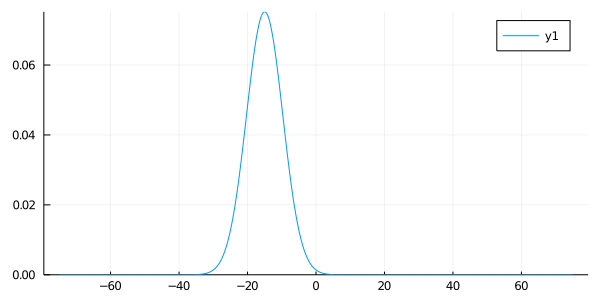

In [54]:
sArgs = SystemArgs(15, 0.01, 0.0001, .5, 8192)

anim, prob   = RunSimulation2(sArgs, 2048, 100, true)
println("v =0.5, mf=4096, travel prob is $prob")
plotAnimationResult2(anim, "v_05_m_4096.gif")

Algorithm set up:

Initiate:

Set up system with width 4a: $x\in[-2a, 2a]$

Start with gaussian wave centred at $x_0 = -a$ with $k>0$

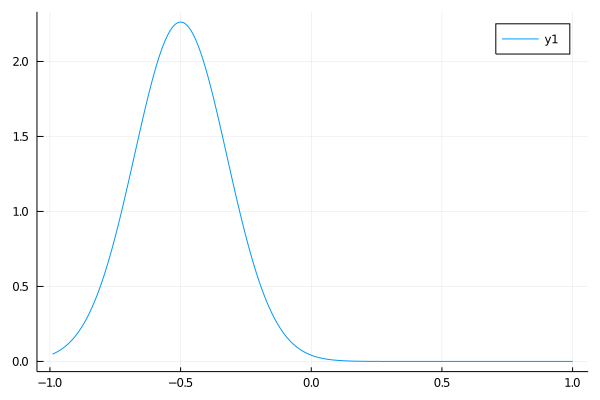

In [6]:
a = 0.5

dx = 0.01
N = Int(4 * a/dx)

x = (Array(1:N) .- 0.5 * N) .* dx
psi_x = gauss_x(x, 0.5 * a, -a, 5)

P_x = to_real_normal(x, psi_x)

plot(x, P_x)